In [3]:
import pandas as pd
import numpy as np

def analyze_and_save_windows(prices, ticker="SIM", save_files=True):
    """
    Analyzes price series as a single continuous ticker without block segmentation.
    """
    # 1. Setup
    HORIZONS = 5 * (np.arange(26) + 1)   
    price_series = pd.Series(prices)
    
    # Calculate global log returns
    ret = np.log(price_series).diff().dropna().values
    
    all_rows = []
    scale = np.sqrt(252)

    # 2. Rolling Window Processing (Single Pass)
    for T in HORIZONS:
        i = 0
        while i + T <= len(ret):
            window = ret[i : i + T]
            
            if len(window) < T * 0.8:
                break

            x = window.sum()
            sigma = np.std(window, ddof=0) * scale
            z_raw = x / np.sqrt(T / 252.0)

            # Reject invalid windows
            if np.isfinite(sigma) and sigma > 0 and np.isfinite(z_raw):
                all_rows.append({
                    "ticker": ticker,
                    "date": i + T, 
                    "T": T,
                    "z_raw": float(z_raw),
                    "sigma": float(sigma)
                })
            i += T # Non-overlapping windows

    if not all_rows:
        return None

    # 3. Data Processing and Global De-meaning
    df = pd.DataFrame(all_rows)
    df = df[np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)]
    
    # De-mean globally across the entire simulation per Horizon T
    df["z"] = df.groupby(["ticker", "T"])["z_raw"].transform(lambda g: g - g.mean())
    df = df.drop(columns="z_raw").dropna().reset_index(drop=True)

    # 4. Exporting
    if save_files:
        # Save analysis partitions
        n = len(df) // 3
        if n > 0:
            df.iloc[:n].to_parquet("dataset_part1.parquet")
            df.iloc[n:2*n].to_parquet("dataset_part2.parquet")
            df.iloc[2*n:].to_parquet("dataset_part3.parquet")
            print(f"Saved {len(df)} windows for single ticker: {ticker}")

        # Save raw prices if length is exactly 100k
        if len(prices) == 100000:
            pd.DataFrame({
                "Day": range(1, len(prices) + 1),
                "Price": prices,
            }).to_csv("simulated_prices.csv", index=False)
            print("Saved 100k prices to simulated_prices.csv")

    return df

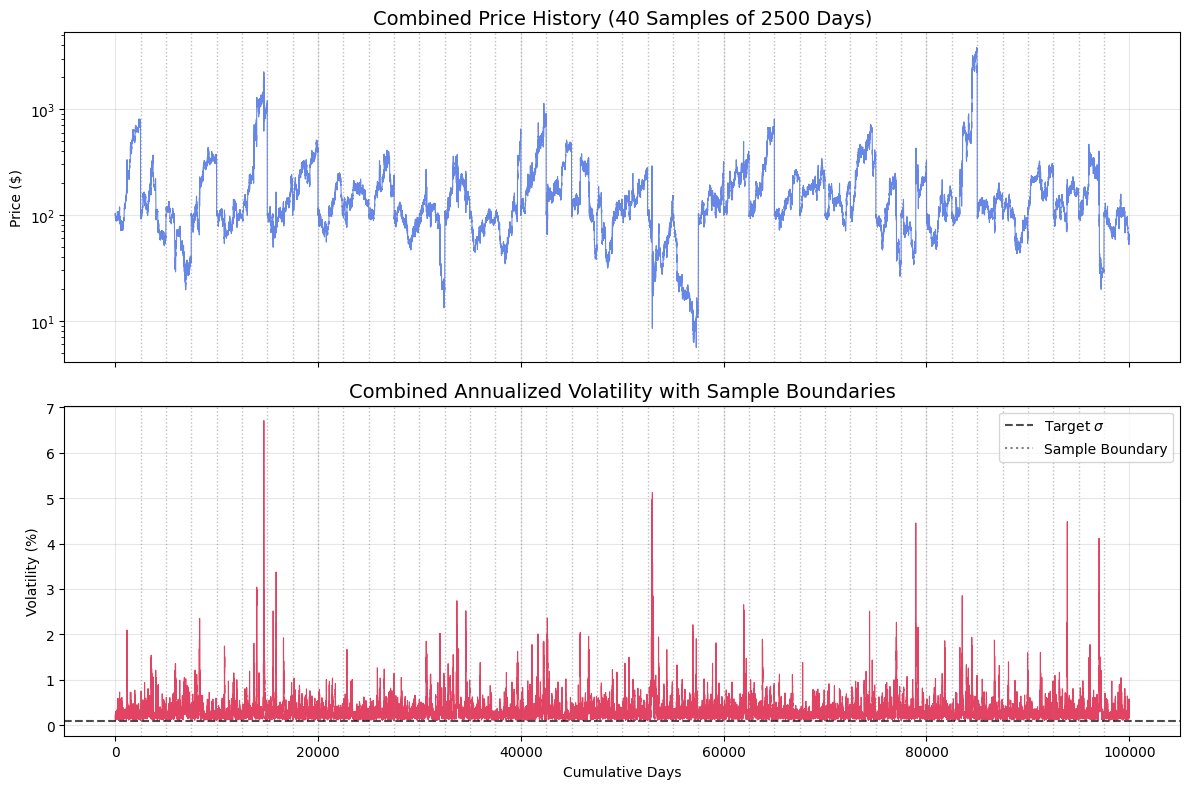

Saved 77073 windows for single ticker: SIM
Saved 100k prices to simulated_prices.csv


,ticker,date,T,sigma,z
0,SIM,5,5,0.066677,0.113493
1,SIM,10,5,0.092882,0.135616
2,SIM,15,5,0.113853,-0.253969
3,SIM,20,5,0.102774,-0.273375
4,SIM,25,5,0.180549,-0.044881
...,...,...,...,...,...
77068,SIM,99450,130,0.166775,0.151610
77069,SIM,99580,130,0.390179,-0.636395
77070,SIM,99710,130,0.273827,0.300161
77071,SIM,99840,130,0.236270,-0.168748


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Global Configuration ---
# N is now days per sample, num_samples is how many independent runs to stitch together
N = 2500             # Days per sample (approx 10 years)
num_samples = 40     # Number of independent simulations
trading_days = 252   # Number of trading days per year
S0 = 100             # Initial stock price

# --- 2. Model Parameters ---
sigma_annual = 0.0956   
mu_annual = 0.0967     
lam = 0.7456               

# sigma_annual = 0.090   
# mu_annual = 0.080     
# lam = 0.785               

# for 1M
# NEW BEST >> Lam:0.785 Mu:0.080 Sig:0.090 | R2: 0.9968

# --- 3. Derivative Model Components ---
target_V_daily = (sigma_annual**2) / trading_days
omega = target_V_daily * (1 - lam)

# Global lists to store the combined "staged" data
all_prices = []
all_vols = []

np.random.seed(42)

# --- 4. Simulation Loop (Multiple Samples) ---
for s in range(num_samples):
    # Unique but reproducible seed for each sample
    #np.random.seed(42 + s)
    
    # Reset for each sample
    sample_prices = [S0]
    sample_vols = []
    V = target_V_daily 

    for i in range(1, N):
        current_sigma_daily = np.sqrt(V)
        sample_vols.append(current_sigma_daily * np.sqrt(trading_days))

        Z = np.random.normal(0, 1)
        log_return = (mu_annual / trading_days) - 0.5 * V + current_sigma_daily * Z
        
        new_price = sample_prices[-1] * np.exp(log_return)
        if new_price < 0.01:
            new_price = 0.01 
        sample_prices.append(new_price)
       
        # Update Variance (GARCH 1,1)
        ret_sq = ((sample_prices[-1] - sample_prices[-2]) / sample_prices[-2])**2
        V = omega + (lam * V) + ((1 - lam - 0.01) * ret_sq)
        #V = max(V, 1e-5)

    # Align lengths
    sample_vols.append(sample_vols[-1])
    
    # Stitch this sample into the global history
    all_prices.extend(sample_prices)
    all_vols.extend(sample_vols)

# --- 5. Visualization (Updated with Boundary Lines) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Plot: Price History
ax1.plot(all_prices, color='royalblue', linewidth=0.8, alpha=0.8)
ax1.set_title(f"Combined Price History ({num_samples} Samples of {N} Days)", fontsize=14)
ax1.set_ylabel("Price ($)")
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Bottom Plot: Volatility History
ax2.plot(all_vols, color='crimson', linewidth=0.8, alpha=0.8)
ax2.axhline(y=sigma_annual, color='black', linestyle='--', alpha=0.7, label=r'Target $\sigma$')
ax2.set_title(r"Combined Annualized Volatility with Sample Boundaries", fontsize=14)
ax2.set_ylabel("Volatility (%)")
ax2.set_xlabel("Cumulative Days")
ax2.grid(True, alpha=0.3)

# --- ADD VERTICAL BOUNDARY LINES ---
for s in range(1, num_samples):
    boundary_day = s * N
    # Add line to Price plot
    ax1.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    # Add line to Volatility plot
    ax2.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add a single label for the boundary lines to the legend
ax2.plot([], [], color='gray', linestyle=':', label='Sample Boundary')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- 6. Window Analysis ---
# Using the combined prices for the rolling analysis
display(analyze_and_save_windows(all_prices))

In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def qvar(z, s0, zoff):    # define q-variance function, parameter is minimal volatility s0 and zoff
    return (s0**2 + (z - zoff)**2 / 2)

# --- 1. Optimization Settings ---
# Defining the search space for all 3 variables
lam_range = np.linspace(0.74, 0.75, 10)       # Persistence
mu_range = np.linspace(0.09, 0.11, 10)        # Annual Drift
sigma_range = np.linspace(0.09, 0.1, 10)     # Target Annual Vol

# lam_range = [0.78]       # Persistence
# mu_range = [0.075]        # Annual Drift
# sigma_range = [0.085]     # Target Annual Vol

best_r2 = -np.inf
best_params = None

print(f"Starting 3D Grid Search ({len(lam_range)*len(mu_range)*len(sigma_range)} combinations)...")
print("-" * 60)

for l in lam_range:
    for m in mu_range:
        for s_ann in sigma_range:
            # --- 2. Simulation Logic ---
            all_prices = []
            target_V_daily = (s_ann**2) / 252
            omega = target_V_daily * (1 - l)
            
            np.random.seed(42)

            # Using 40 samples for a balance of speed and statistical significance
            for s_idx in range(40): 
                
                sample_prices = [100]
                V = target_V_daily
                
                for _ in range(1, 2500):
                    Z = np.random.normal(0, 1)
                    # GARCH Price Update
                    log_ret = (m / 252) - 0.5 * V + np.sqrt(V) * Z
                    new_p = sample_prices[-1] * np.exp(log_ret)
                    sample_prices.append(max(new_p, 0.01))
                    
                    # GARCH Variance Update
                    ret_sq = ((sample_prices[-1] - sample_prices[-2]) / sample_prices[-2])**2
                    V = omega + (l * V) + ((1 - l - 0.01) * ret_sq)
                    #V = max(V, 1e-6)
                all_prices.extend(sample_prices)

            # --- 3. Process Windows ---
            # Call your existing function (ensure it returns the DataFrame)
            df_temp = analyze_and_save_windows(all_prices, ticker=f"L{l}_M{m}_S{s_ann}", save_files = False)
            #display(df_temp)

            if df_temp is not None and not df_temp.empty:
                df_temp["var"] = df_temp.sigma**2

                zmax = 0.6  #0.6 or 1
                delz = 0.025*2
                nbins = int(2*zmax/delz + 1)
                bins = np.linspace(-zmax, zmax, nbins)         # fixed bins
                ymax = 0.35

                # create data frame with e.g. zbin = (-0.601, -0.55], z_mid, sigma
                binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
                    .groupby('z_bin',observed=False)
                    .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                    .dropna())

                #display(binned)
                # --- 4. Curve Fitting & R2 ---
                try:
                    if len(binned) < 5: continue # Skip if not enough data points
                    
                    popt = [0.2586, 0.0214]  # same as optimized fit to data  # for competition score should fit original parabola
                    #popt, _ = curve_fit(qvar, binned.z_mid, binned["var"], p0=[0.2, 0])
                    fitted = qvar(binned.z_mid, popt[0], popt[1])
                    
                    ss_res = np.sum((binned["var"] - fitted)**2)
                    ss_tot = np.sum((binned["var"] - binned["var"].mean())**2)
                    r2 = 1 - (ss_res / ss_tot)
                    
                    if r2 > best_r2:
                        best_r2 = r2
                        best_params = {
                            'lam': l, 'mu': m, 'sigma': s_ann, 
                            'popt': popt, 'r2': r2
                        }
                        print(f" NEW BEST >> Lam:{l:.4f} Mu:{m:.4f} Sig:{s_ann:.4f} | R2: {r2:.3f} Sigma0: {popt[0]:.3f} Zoff: {popt[1]:.3f}")
                except Exception as e:
                    continue

# --- 5. Results Summary ---
print("-" * 60)
if best_params:
    print("OPTIMIZATION COMPLETE")
    print(f"Winner Lambda: {best_params['lam']:.4f}")
    print(f"Winner Mu:     {best_params['mu']:.4f}")
    print(f"Winner Sigma:  {best_params['sigma']:.4f}")
    print(f"Max R2:        {best_params['r2']:.3f}")
else:
    print("No valid fits were found. Try increasing simulation length N or widening parameter ranges.")

Starting 3D Grid Search (1000 combinations)...
------------------------------------------------------------
 NEW BEST >> Lam:0.7400 Mu:0.0900 Sig:0.0900 | R2: 0.975 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7400 Mu:0.0900 Sig:0.0911 | R2: 0.977 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7400 Mu:0.0900 Sig:0.0922 | R2: 0.989 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7411 Mu:0.0900 Sig:0.0922 | R2: 0.990 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7411 Mu:0.0944 Sig:0.0922 | R2: 0.990 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7411 Mu:0.0989 Sig:0.0922 | R2: 0.990 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7422 Mu:0.0900 Sig:0.0933 | R2: 0.992 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7422 Mu:0.0967 Sig:0.0933 | R2: 0.993 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7433 Mu:0.0989 Sig:0.0933 | R2: 0.993 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7433 Mu:0.1033 Sig:0.0933 | R2: 0.994 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7444 Mu:0.1033 Sig:0.0944 | R2: 0.994 Sigma